<a href="https://colab.research.google.com/github/rama96/hugging-face/blob/master/Chapter2_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 38.8 MB/s 
     |████████████████████████████████| 120 kB 68.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 7.0 MB/s 
     |████████████████████████████████| 212 kB 54.9 MB/s 
     |████████████████████████████████| 115 kB 43.9 MB/s 
     |████████████████████████████████| 127 kB 56.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [8]:
import torch 
from datasets import load_dataset , list_datasets
from transformers import AutoTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Load and View Datasets

In [2]:
from datasets import list_datasets , load_dataset

all_datasets = list_datasets()
print(f"Total Number of available datasets , {len(all_datasets)}")
all_datasets[:20]
# emotions = load_dataset("emotion")
# emotions


Total Number of available datasets , 9189


['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews',
 'allocine',
 'alt',
 'amazon_polarity',
 'amazon_reviews_multi',
 'amazon_us_reviews',
 'ambig_qa',
 'americas_nli',
 'ami',
 'amttl',
 'anli']

In [3]:
# Picking a dataset from this 
reviews = load_dataset("yelp_review_full")
reviews


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

## 2. EDA

In [4]:
reviews["train"].features

{'label': ClassLabel(num_classes=5, names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

Outputs are in the form of a dictionary 

In [5]:
train_ds = reviews["train"]
train_ds[0:5]


{'label': [4, 1, 3, 3, 0],
 'text': ["dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.",
  "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You 

In [6]:
train_ds[0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [7]:
train_ds.column_names

['label', 'text']

In [8]:
reviews.set_format(type = "pandas")
df = reviews["train"][:]
df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [9]:
def label2row(row):
  return reviews["train"].features["label"].int2str(row)

In [10]:
df['label_name'] = df['label'].apply(label2row)
df

,label,text,label_name
0,4,dr. goldberg offers everything i look for in a...,5 stars
1,1,"Unfortunately, the frustration of being Dr. Go...",2 star
2,3,Been going to Dr. Goldberg for over 10 years. ...,4 stars
3,3,Got a letter in the mail last week that said D...,4 stars
4,0,I don't know what Dr. Goldberg was like before...,1 star
...,...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...,5 stars
649996,0,Phone calls always go to voicemail and message...,1 star
649997,0,Looks like all of the good reviews have gone t...,1 star
649998,4,I was able to once again rely on Yelp to provi...,5 stars


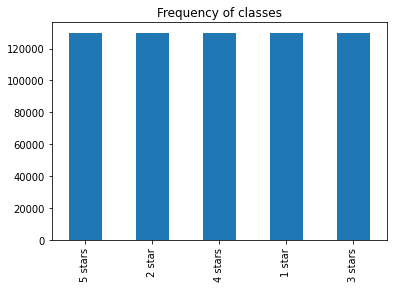

In [11]:
import matplotlib.pyplot as plt

df['label_name'].value_counts().plot.bar()
plt.title("Frequency of classes")
plt.show()

# 

Looks like a very balanced class . If there are imbalances in class , following can be done <br>

1. Randomply Oversample the minority class <br>
2. Randomly undersample the majrity class <br>
3. gather more labeled data from underrepresented classes <br>

refer to Imabalanced-learn library

In [12]:
df[:10]["text"].str.split()

0    [dr., goldberg, offers, everything, i, look, f...
1    [Unfortunately,, the, frustration, of, being, ...
2    [Been, going, to, Dr., Goldberg, for, over, 10...
3    [Got, a, letter, in, the, mail, last, week, th...
4    [I, don't, know, what, Dr., Goldberg, was, lik...
5    [Top, notch, doctor, in, a, top, notch, practi...
6    [Dr., Eric, Goldberg, is, a, fantastic, doctor...
7    [I'm, writing, this, review, to, give, you, a,...
8    [Wing, sauce, is, like, water., Pretty, much, ...
9    [Decent, range, somewhat, close, to, the, city...
Name: text, dtype: object

In [13]:
df["words_per_review"] = df["text"].str.split().apply(len)


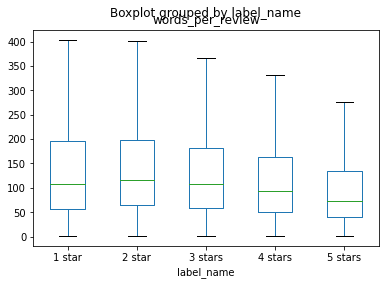

In [14]:
df.boxplot("words_per_review",by="label_name",grid =False , showfliers=False)

In [15]:
reviews.reset_format()

https://karpathy.github.io/2019/04/25/recipe/

## 3. Tokenization 

### 3.1 Character tokenization


In [ ]:
import torch
import torch.nn.functional as F

text = " I'm currently reading the book about NLP using huggingface "
tokenized_text = list(text)

token2idx = {ch:idx for idx , ch in enumerate(set(tokenized_text))}

input_ids = [token2idx[x] for x in tokenized_text]
print("Displaying the first 5 tokens" , input_ids[:5])

input_ids = torch.tensor(input_ids)

one_hot_encodings = F.one_hot(input_ids , num_classes = len(token2idx))
print("One hot encoding shape" , one_hot_encodings.shape)

print(one_hot_encodings[:2])

print(f"Token : {tokenized_text[3]}")
print(f"Tensor Index : {input_ids[3]}")
print(f"One hot encodings : {one_hot_encodings[3]}")




Displaying the first 5 tokens [23, 0, 22, 20, 23]
One hot encoding shape torch.Size([60, 25])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])
Token : m
Tensor Index : 20
One hot encodings : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0])


### 3.2 Words Tokenization

In [ ]:
import torch
import torch.nn.functional as F

text = " I'm currently reading the book about NLP using huggingface "
tokenized_text = text.split()

token2idx = {ch:idx for idx , ch in enumerate(set(tokenized_text))}

input_ids = [token2idx[x] for x in tokenized_text]
print("Displaying the first 5 tokens" , input_ids[:5])

input_ids = torch.tensor(input_ids)

one_hot_encodings = F.one_hot(input_ids , num_classes = len(token2idx))
print("One hot encoding shape" , one_hot_encodings.shape)

print(one_hot_encodings[:2])

print(f"Token : {tokenized_text[3]}")
print(f"Tensor Index : {input_ids[3]}")
print(f"One hot encodings : {one_hot_encodings[3]}")




Displaying the first 5 tokens [7, 1, 0, 2, 5]
One hot encoding shape torch.Size([9, 9])
tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0]])
Token : the
Tensor Index : 2
One hot encodings : tensor([0, 0, 1, 0, 0, 0, 0, 0, 0])


### 3.3 Subword Tokenization 

In [3]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

AutoTokenizer belongs to Auto class that automatically retrieves model config or we can directly load the distilbert Tokenizer as well . Both essentially lead to the same tokenizer

In [4]:
from transformers import DistilBertTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### 3.4 Playgrund with tokenizers

In [17]:
text = "Hello , This is the new transformers course by HuggingFace"
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 7592, 1010, 2023, 2003, 1996, 2047, 19081, 2607, 2011, 17662, 12172, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'hello',
 ',',
 'this',
 'is',
 'the',
 'new',
 'transformers',
 'course',
 'by',
 'hugging',
 '##face',
 '[SEP]']

You can see that there are special tokens like [CLS] , [SEP] that indicate starting and ending of sequence

In [19]:
print(tokenizer.convert_tokens_to_string(tokens))
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)


[CLS] hello, this is the new transformers course by huggingface [SEP]
30522
512
['input_ids', 'attention_mask']


In [20]:
print(tokenizer.vocab)

{'betrayed': 12056, 'scared': 6015, '##ø': 16415, '##helm': 24546, 'saloon': 17078, 'opportunities': 6695, 'expose': 14451, 'flair': 22012, 'constructions': 21913, 'commence': 22825, 'alignment': 12139, '##shan': 9688, '[unused569]': 574, '126': 14010, '[unused645]': 650, 'levels': 3798, 'decorate': 29460, 'ancestry': 11377, 'havilland': 23994, 'scoop': 23348, 'boutique': 24611, 'wright': 6119, '##kos': 15710, 'fulfill': 13883, '##28': 22407, '##mac': 22911, '##し': 30183, 'godfrey': 18238, '##ovich': 12303, 'franz': 8965, 'contents': 8417, '##iest': 10458, '##lena': 20844, 'hutchinson': 17165, 'reputed': 22353, 'diane': 12082, 'humiliation': 21171, '##張': 30370, 'coordination': 12016, 'dortmund': 23912, 'wanda': 20848, 'lviv': 23814, '##mie': 9856, 'reorganization': 17118, 'attacked': 4457, '[unused585]': 590, 'ibn': 7839, 'murderer': 13422, 'banjo': 16698, 'plume': 26888, 'hammond': 11309, '##uf': 16093, '##ddled': 28090, 'sighs': 19906, '14': 2403, 'sobs': 21503, 'syntax': 20231, '##

In [21]:
def tokenize(ds):
  return tokenizer(ds["text"],
                   padding = True , # Pads the examples with 0s to size of longest one in the batch
                   truncation = True ) # Truncates string to model_max_length size
print(tokenize(reviews["train"][:2]))


{'input_ids': [[101, 2852, 1012, 18522, 4107, 2673, 1045, 2298, 2005, 1999, 1037, 2236, 18742, 1012, 2002, 1005, 1055, 3835, 1998, 3733, 2000, 2831, 2000, 2302, 2108, 9161, 6026, 1025, 2002, 1005, 1055, 2467, 2006, 2051, 1999, 3773, 2010, 5022, 1025, 2002, 1005, 1055, 6989, 2007, 1037, 2327, 1011, 18624, 2902, 1006, 27935, 1007, 2029, 2026, 3008, 2031, 4541, 2000, 2033, 2003, 2200, 2590, 1999, 2553, 2242, 6433, 1998, 2017, 2342, 5970, 1025, 1998, 2017, 2064, 2131, 6523, 7941, 2015, 2000, 2156, 15744, 2302, 2383, 2000, 2156, 2032, 2034, 1012, 2428, 1010, 2054, 2062, 2079, 2017, 2342, 1029, 1045, 1005, 1049, 3564, 2182, 2667, 2000, 2228, 1997, 2151, 10821, 1045, 2031, 2055, 2032, 1010, 2021, 1045, 1005, 1049, 2428, 5059, 1037, 8744, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 6854, 1010, 1996, 9135, 1997, 2108, 2852, 1012, 18522, 1005, 1055, 5776, 2003, 1037, 9377, 1997, 1996, 3325, 1045, 1005, 2310, 2018, 2007, 2061, 2116, 2060, 

You see trailing 0s in the text which are the result of padding to longest size in the batch. Intresting thing here is that you also see attention mask values as 0 as an indication to the model to ignore the padded values

In [ ]:
# reviews_encoded = reviews.map(tokenize,batched = True , # Lets the reviews to be processed in batches
#                               batch_size = None # Tokenize will get applied on full dataset in a single batch
#                               )
# reviews_encoded

Skip this step if you've already encoded the batch

In [ ]:
reviews_encoded = reviews.map(tokenize,batched = True , # Lets the reviews to be processed in batches
                              batch_size = 5000 # Tokenize will get applied on full dataset in a single batch
                              )


  0%|          | 0/130 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [22]:
!huggingface-cli login



        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [24]:
# reviews_encoded.push_to_hub("Ramamurthi/yelp_reviews_encoded")

In [27]:
reviews_encoded = load_dataset("Ramamurthi/yelp_reviews_encoded",use_auth_token=True)
reviews_encoded

Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Ramamurthi___parquet/Ramamurthi--yelp_reviews_encoded-e90ca4a5895d39c9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [25]:
reviews_encoded.set_format(type = "pandas")
df = reviews_encoded["train"][:]


In [26]:
df['input_ids'].iloc[0]

array([  101,  2852,  1012, 18522,  4107,  2673,  1045,  2298,  2005,
        1999,  1037,  2236, 18742,  1012,  2002,  1005,  1055,  3835,
        1998,  3733,  2000,  2831,  2000,  2302,  2108,  9161,  6026,
        1025,  2002,  1005,  1055,  2467,  2006,  2051,  1999,  3773,
        2010,  5022,  1025,  2002,  1005,  1055,  6989,  2007,  1037,
        2327,  1011, 18624,  2902,  1006, 27935,  1007,  2029,  2026,
        3008,  2031,  4541,  2000,  2033,  2003,  2200,  2590,  1999,
        2553,  2242,  6433,  1998,  2017,  2342,  5970,  1025,  1998,
        2017,  2064,  2131,  6523,  7941,  2015,  2000,  2156, 15744,
        2302,  2383,  2000,  2156,  2032,  2034,  1012,  2428,  1010,
        2054,  2062,  2079,  2017,  2342,  1029,  1045,  1005,  1049,
        3564,  2182,  2667,  2000,  2228,  1997,  2151, 10821,  1045,
        2031,  2055,  2032,  1010,  2021,  1045,  1005,  1049,  2428,
        5059,  1037,  8744,  1012,   102,     0,     0,     0,     0,
           0,     0,

In [27]:
tokenizer.convert_ids_to_tokens(list(df['input_ids'].iloc[0]))

['[CLS]',
 'dr',
 '.',
 'goldberg',
 'offers',
 'everything',
 'i',
 'look',
 'for',
 'in',
 'a',
 'general',
 'practitioner',
 '.',
 'he',
 "'",
 's',
 'nice',
 'and',
 'easy',
 'to',
 'talk',
 'to',
 'without',
 'being',
 'patron',
 '##izing',
 ';',
 'he',
 "'",
 's',
 'always',
 'on',
 'time',
 'in',
 'seeing',
 'his',
 'patients',
 ';',
 'he',
 "'",
 's',
 'affiliated',
 'with',
 'a',
 'top',
 '-',
 'notch',
 'hospital',
 '(',
 'nyu',
 ')',
 'which',
 'my',
 'parents',
 'have',
 'explained',
 'to',
 'me',
 'is',
 'very',
 'important',
 'in',
 'case',
 'something',
 'happens',
 'and',
 'you',
 'need',
 'surgery',
 ';',
 'and',
 'you',
 'can',
 'get',
 'refer',
 '##ral',
 '##s',
 'to',
 'see',
 'specialists',
 'without',
 'having',
 'to',
 'see',
 'him',
 'first',
 '.',
 'really',
 ',',
 'what',
 'more',
 'do',
 'you',
 'need',
 '?',
 'i',
 "'",
 'm',
 'sitting',
 'here',
 'trying',
 'to',
 'think',
 'of',
 'any',
 'complaints',
 'i',
 'have',
 'about',
 'him',
 ',',
 'but',
 'i',
 "

In [28]:
df['attention_mask'].iloc[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
reviews_encoded.reset_format()

## 4. Model Application

### 4.1 Model definition

In [30]:
import torch 
from transformers import AutoModel

model_ckpt="distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now that we've loaded then models , it's important to load the inputs to device since the model is loaded to device


In [31]:
sample_text = "this is a sample text"
inputs = tokenizer(sample_text , 
                   return_tensors = "pt" ## Returns Pytorch tensors
                   )
inputs


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 7099, 3793,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [32]:
inputs = {k:v.to(device) for k,v in inputs.items()}
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 7099, 3793,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [33]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad(): # to disable auto calculation of grads
  outputs = model(**inputs)
print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.2274, -0.1707,  0.0797,  ..., -0.1128,  0.2172,  0.4858],
         [-0.7078, -0.4579, -0.0390,  ..., -0.3485,  0.4364,  0.4257],
         [-0.4368, -0.2847,  0.2122,  ..., -0.1118,  0.0647,  1.1617],
         ...,
         [ 0.2675, -0.3272,  0.0554,  ..., -0.3997,  0.2540,  0.0608],
         [-0.1498, -0.2747, -0.0656,  ...,  0.0277,  0.1228,  0.1980],
         [ 1.0124,  0.1144, -0.4184,  ...,  0.2290, -0.7445, -0.1556]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [34]:
inputs['input_ids'].shape

torch.Size([1, 7])

In [35]:
print(outputs.last_hidden_state.shape)
# batchsize , input_size , hidden_dim

print(outputs.last_hidden_state[:,0].shape)
# batchsize ,hidden_dim of the fist token [CLS]

torch.Size([1, 7, 768])
torch.Size([1, 768])


In [36]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [37]:
def extract_hidden_states(batch):
  
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names } # Converting the input_ids and attention masks to tensors and placing it on GPU
  
  with torch.no_grad():
    
    last_hidden_state = model(**inputs).last_hidden_state # Extracting last hidden states
    
    return { "hidden_state": last_hidden_state[:,0].cpu().numpy() } # returns the hidden layer outputs corresponding to the first input token of the string , converts the same into a numpy array
  


In [38]:
reviews_encoded.set_format("torch",
                           columns = ["input_ids" , "attention_mask","label"]
                          )


In [39]:
import gc
# del df
gc.collect()

torch.cuda.empty_cache()

### 4.2 Reducing datasets size

In [40]:
reviews_encoded_train_ds = reviews_encoded["train"]
reviews_encoded_test_ds = reviews_encoded["test"]
reviews_encoded_test_ds , reviews_encoded_train_ds

(Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 50000
 }), Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 650000
 }))

In [41]:
train_dataset , validation_dataset= reviews_encoded_train_ds.train_test_split(test_size=0.90).values()
test_ds , test_2_ds = reviews_encoded_test_ds.train_test_split(test_size=0.50).values()

train_dataset , test_ds

(Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 65000
 }), Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 25000
 }))

In [42]:
train_ds , valid_ds = train_dataset.train_test_split(test_size=0.25).values()
train_ds , valid_ds


(Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 48750
 }), Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 16250
 }))

In [43]:
import datasets
reviews_encoded_modified = datasets.DatasetDict({"train":train_ds,
                                                 "valid":valid_ds,
                                                 "test":test_ds})
reviews_encoded_modified

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 48750
    })
    valid: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 16250
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [44]:
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [38]:
reviews_hidden = reviews_encoded_modified.map(extract_hidden_states , batched = True , batch_size = 256)

reviews_hidden.push_to_hub("Ramamurthi/yelp_reviews_encoded_hidden_outputs_truncated")

  0%|          | 0/191 [00:00<?, ?ba/s]

  0%|          | 0/64 [00:00<?, ?ba/s]

  0%|          | 0/98 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:2168: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  FutureWarning,


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [39]:
reviews_hidden

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 48750
    })
    valid: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16250
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 25000
    })
})

### 4.3 Loading reviews hidden

In [26]:
reviews_hidden = load_dataset("Ramamurthi/yelp_reviews_encoded_hidden_outputs_truncated",use_auth_token=True)
reviews_hidden

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 48750
    })
    valid: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16250
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 25000
    })
})

In [5]:
reviews_hidden["train"].column_names

['label', 'text', 'input_ids', 'attention_mask', 'hidden_state']

In [6]:
reviews_hidden.set_format(type = "pandas")
df = reviews_hidden["train"][:]
df

,label,text,input_ids,attention_mask,hidden_state
0,3,I came here twice for lunch on my trip and bot...,"[101, 1045, 2234, 2182, 3807, 2005, 6265, 2006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.12881449, -0.17844887, 0.04598793, 0.06840..."
1,3,just went to a wine tasting for charity @ stud...,"[101, 2074, 2253, 2000, 1037, 4511, 18767, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.11288056, -0.10590317, 0.07739841, 0.036335..."
2,0,Vultures who prey on the misfortune of others....,"[101, 27588, 2015, 2040, 8336, 2006, 1996, 286...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.2755051, 0.11566341, -0.019305333, -0.01654..."
3,4,This was my first time at this salon. Bonus th...,"[101, 2023, 2001, 2026, 2034, 2051, 2012, 2023...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0930072, 0.009606739, 0.25004992, -0.183496..."
4,1,"The ambiance is super cute, but unfortunately ...","[101, 1996, 2572, 15599, 3401, 2003, 3565, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.01172894, 0.03674047, -0.052363124, -0.131..."
...,...,...,...,...,...
48745,0,"Pants are not sorted to size, pants and shirts...","[101, 6471, 2024, 2025, 19616, 2000, 2946, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.21641815, -0.2234749, -0.096612565, 0.04315..."
48746,1,Disappointed in this location of Hash House......,"[101, 9364, 1999, 2023, 3295, 1997, 23325, 216...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.051553424, 0.024360327, -0.05037211, -0.068..."
48747,2,We ordered the Jack Daniel's burger along with...,"[101, 2057, 3641, 1996, 2990, 3817, 1005, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.1223948, 0.0143415155, -0.22280404, 0.10005..."
48748,1,You will like this place if you like a wild cr...,"[101, 2017, 2097, 2066, 2023, 2173, 2065, 2017...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.050924595, -0.0039389916, 0.0024438424, -0...."


In [7]:
reviews_hidden.reset_format()

In [8]:
len(reviews_hidden["train"][1]['hidden_state'])

768

## 5 . Creating feaature Matrix

In [9]:
import numpy as np
X_train = np.array(reviews_hidden['train']['hidden_state'])
X_valid = np.array(reviews_hidden['valid']['hidden_state'])
y_train = np.array(reviews_hidden['train']['label'])
y_valid = np.array(reviews_hidden['valid']['label'])

X_train.shape , X_valid.shape , y_train.shape , y_valid.shape


((48750, 768), (16250, 768), (48750,), (16250,))

In [10]:
y_train[1]

3

In [11]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=524a82a50d97352b9a4e1d020bff1b35fe04513f8a45ad5aa09bb49c5ee84e4f
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=e3885715ed2fa94d190c078f3d7928428ec52da5970bb3c211e2ce309870da21
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


UMAP is a dimensionality reduction technique like PCA or SVD

In [12]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components = 2 , metric = "cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_ , columns = ["X","Y"])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,5.049393,3.653873,3
1,2.134968,4.614736,3
2,0.873209,2.493644,0
3,0.742275,0.467945,4
4,5.519978,3.827777,1


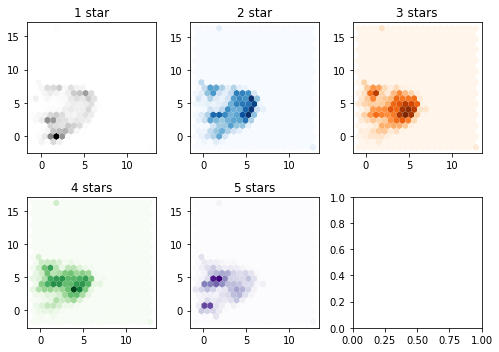

In [13]:
import matplotlib.pyplot as plt
fig , axes = plt.subplots(2,3 , figsize = (7,5))
axes = axes.flatten()
cmaps = ["Greys","Blues","Oranges","Greens","Purples"]
labels = reviews_hidden['train'].features['label'].names

for i , (label , cmap) in enumerate(zip(labels,cmaps)):
  df_emb_sub = df_emb[df_emb['label']==i]
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"] , cmap = cmap , 
                 gridsize = 20 , linewidths=(0,))
  axes[i].set_title(label)
plt.tight_layout()
plt.show()

### 6. Training a simple classifier

In [14]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# lr_clf = LogisticRegression(max_iter = 300)
# lr_clf.fit(X_train , y_train)
# lr_clf.score(X_valid , y_valid)


In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_valid , y_valid)


0.4931076923076923

In [16]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.20381538461538462

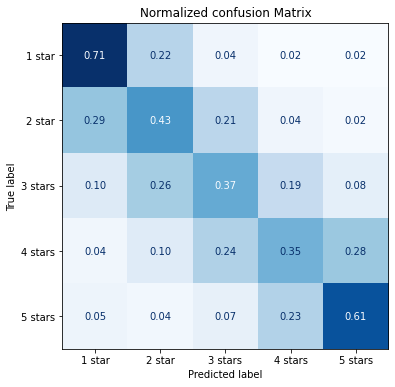

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay , confusion_matrix

def plot_confusion_matrix(y_preds , y_true , labels ):
  cm = confusion_matrix(y_true , y_preds, normalize="true")
  fig , ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap = "Blues" , values_format = ".2f" , ax=ax,colorbar=False)
  plt.title("Normalized confusion Matrix")
  plt.show()
y_preds = clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid,labels)

At least the random forest does a good job in predicting the ratings to nearby number . i.e classifying 4 as 5-3 .

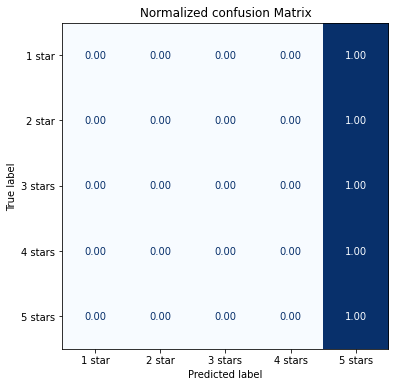

In [18]:
y_preds = dummy_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid,labels)

## 6. Fine-Tuning Transformers

### 6.1 Loading Pretrained Model (DistilBert)

In [4]:
from transformers import AutoModelForSequenceClassification
num_labels = 5
model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt , num_labels = num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

### 6.2 Trainer and TrainingArguments Definition 

In [5]:
from sklearn.metrics import accuracy_score , f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels , preds , average = "weighted")
  accuracy = accuracy_score(labels , preds )
  return {"accuracy":accuracy , "f1" : f1}
  

### Reloading Reviews Encoded

In [32]:
reviews_encoded = load_dataset("Ramamurthi/yelp_reviews_encoded",use_auth_token=True)
reviews_encoded.set_format(type = "pandas")
df = reviews_encoded["train"][:]
df

,label,text,input_ids,attention_mask
0,4,dr. goldberg offers everything i look for in a...,"[101, 2852, 1012, 18522, 4107, 2673, 1045, 229...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,"Unfortunately, the frustration of being Dr. Go...","[101, 6854, 1010, 1996, 9135, 1997, 2108, 2852...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,3,Been going to Dr. Goldberg for over 10 years. ...,"[101, 2042, 2183, 2000, 2852, 1012, 18522, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,Got a letter in the mail last week that said D...,"[101, 2288, 1037, 3661, 1999, 1996, 5653, 2197...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,I don't know what Dr. Goldberg was like before...,"[101, 1045, 2123, 1005, 1056, 2113, 2054, 2852...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...,"[101, 1045, 2018, 1037, 11867, 6657, 19099, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
649996,0,Phone calls always go to voicemail and message...,"[101, 3042, 4455, 2467, 2175, 2000, 2376, 2139...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
649997,0,Looks like all of the good reviews have gone t...,"[101, 3504, 2066, 2035, 1997, 1996, 2204, 4391...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
649998,4,I was able to once again rely on Yelp to provi...,"[101, 1045, 2001, 2583, 2000, 2320, 2153, 1116...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [39]:
# reviews_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [33]:
reviews_encoded.reset_format

### Reloading Reviews Hidden 

In [9]:
reviews_hidden = load_dataset("Ramamurthi/yelp_reviews_encoded_hidden_outputs_truncated",use_auth_token=True)
reviews_hidden

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Ramamurthi___parquet/Ramamurthi--yelp_reviews_encoded_hidden_outputs_truncated-6339a26ae5262e6e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    valid: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16250
    })
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 48750
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 25000
    })
})

In [11]:
reviews_hidden.set_format(type = "pandas")
df = reviews_hidden["train"][:]
df

,label,text,input_ids,attention_mask,hidden_state
0,3,I came here twice for lunch on my trip and bot...,"[101, 1045, 2234, 2182, 3807, 2005, 6265, 2006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.12881449, -0.17844887, 0.04598793, 0.06840..."
1,3,just went to a wine tasting for charity @ stud...,"[101, 2074, 2253, 2000, 1037, 4511, 18767, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.11288056, -0.10590317, 0.07739841, 0.036335..."
2,0,Vultures who prey on the misfortune of others....,"[101, 27588, 2015, 2040, 8336, 2006, 1996, 286...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.2755051, 0.11566341, -0.019305333, -0.01654..."
3,4,This was my first time at this salon. Bonus th...,"[101, 2023, 2001, 2026, 2034, 2051, 2012, 2023...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0930072, 0.009606739, 0.25004992, -0.183496..."
4,1,"The ambiance is super cute, but unfortunately ...","[101, 1996, 2572, 15599, 3401, 2003, 3565, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.01172894, 0.03674047, -0.052363124, -0.131..."
...,...,...,...,...,...
48745,0,"Pants are not sorted to size, pants and shirts...","[101, 6471, 2024, 2025, 19616, 2000, 2946, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.21641815, -0.2234749, -0.096612565, 0.04315..."
48746,1,Disappointed in this location of Hash House......,"[101, 9364, 1999, 2023, 3295, 1997, 23325, 216...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.051553424, 0.024360327, -0.05037211, -0.068..."
48747,2,We ordered the Jack Daniel's burger along with...,"[101, 2057, 3641, 1996, 2990, 3817, 1005, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.1223948, 0.0143415155, -0.22280404, 0.10005..."
48748,1,You will like this place if you like a wild cr...,"[101, 2017, 2097, 2066, 2023, 2173, 2065, 2017...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.050924595, -0.0039389916, 0.0024438424, -0...."


In [12]:
del df
reviews_hidden.reset_format()

In [13]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [25]:
from transformers import Trainer , TrainingArguments

batch_size = 32
logging_steps = len(reviews_hidden["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-yelp-reviews"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 2 , 
                                  learning_rate = 2e-5 , 
                                  per_device_train_batch_size = batch_size , 
                                  per_device_eval_batch_size = batch_size , 
                                  weight_decay = 0.01 , 
                                  evaluation_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = "error"
                                  )

In [26]:
from transformers import Trainer

trainer = Trainer(model = model ,
                  args = training_args , 
                  compute_metrics = compute_metrics , 
                  train_dataset = reviews_hidden["train"] ,
                  eval_dataset = reviews_hidden["valid"] ,
                  tokenizer = tokenizer
                  )
trainer.train()


/content/distilbert-base-uncased-finetuned-yelp-reviews is already a clone of https://huggingface.co/Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.899100,0.839575,0.630154,0.629407
2,0.754000,0.828800,0.641846,0.642494


TrainOutput(global_step=3048, training_loss=0.8264650785782206, metrics={'train_runtime': 5230.6915, 'train_samples_per_second': 18.64, 'train_steps_per_second': 0.583, 'total_flos': 1.29162623616e+16, 'train_loss': 0.8264650785782206, 'epoch': 2.0})

In [27]:
trainer.push_to_hub(commit_message="1st Training (2 epochs) Completed")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Sep03_17-32-14_55d54862db28/events.out.tfevents.1662226340.55d54862db28.74.10:  64%|######4  …

To https://huggingface.co/Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews
   c7b8cc0..68f0734  main -> main

   c7b8cc0..68f0734  main -> main

To https://huggingface.co/Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews
   68f0734..3e09a6d  main -> main

   68f0734..3e09a6d  main -> main



'https://huggingface.co/Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews/commit/68f0734cc6d34c72e215603f1a51f03da291d1d7'

In [28]:
preds_output = trainer.predict(reviews_hidden["valid"])
preds_output.metrics

{'test_loss': 0.8288000226020813,
 'test_accuracy': 0.6418461538461538,
 'test_f1': 0.6424942003355615,
 'test_runtime': 299.3739,
 'test_samples_per_second': 54.28,
 'test_steps_per_second': 1.697}

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay , confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds , y_true , labels ):
  cm = confusion_matrix(y_true , y_preds, normalize="true")
  fig , ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap = "Blues" , values_format = ".2f" , ax=ax,colorbar=False)
  plt.title("Normalized confusion Matrix")
  plt.show()

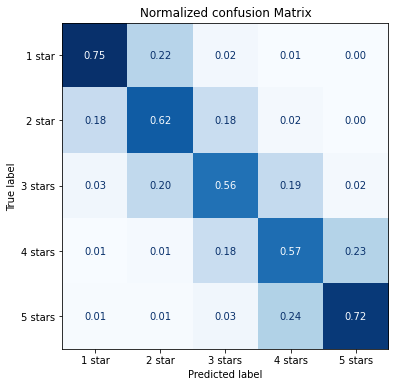

In [35]:
y_preds = np.argmax(preds_output.predictions ,axis = 1)
y_valid = np.array(reviews_hidden['valid']['label'])
labels = reviews_hidden['train'].features['label'].names

plot_confusion_matrix(y_preds , y_valid , labels)


In [53]:
preds_output_test = trainer.predict(reviews_hidden["test"])
preds_output_test.metrics

{'test_loss': 0.8187622427940369,
 'test_accuracy': 0.6444,
 'test_f1': 0.6449526558782509,
 'test_runtime': 461.2026,
 'test_samples_per_second': 54.206,
 'test_steps_per_second': 1.696}

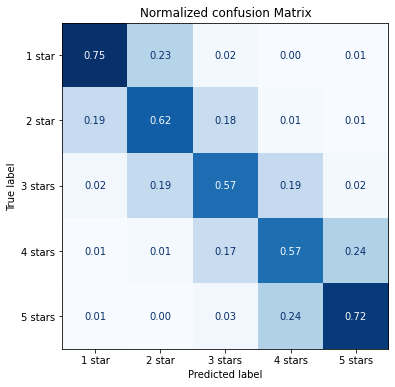

In [54]:
y_preds_test = np.argmax(preds_output_test.predictions ,axis = 1)
y_test = np.array(reviews_hidden['test']['label'])
labels = reviews_hidden['train'].features['label'].names

plot_confusion_matrix(y_preds_test , y_test , labels)


## 7.Error Analysis 

In [36]:
from torch.nn.functional import cross_entropy 

def forward_pass_with_label(batch):
  
  inputs = { k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names }
  
  with torch.no_grad():
    output=model(**inputs)
    pred_label = torch.argmax(output.logits , axis =-1)
    loss = cross_entropy(output.logits , 
                         batch['label'].to(device) ,
                         reduction="none")
  
  return {"loss":loss.cpu().numpy() , 
            "predicted_label":pred_label.cpu().numpy()
            }


In [37]:
reviews_hidden.set_format("torch",columns=["input_ids","attention_mask","label"])

In [38]:
reviews_hidden["valid"] = reviews_hidden["valid"].map(forward_pass_with_label 
                                                      , batched=True 
                                                      , batch_size=16)


  0%|          | 0/1016 [00:00<?, ?ba/s]

In [39]:
reviews_hidden["test"] = reviews_hidden["test"].map(forward_pass_with_label 
                                                      , batched=True 
                                                      , batch_size=16)


  0%|          | 0/1563 [00:00<?, ?ba/s]

In [48]:
def label_int2str(row):
  return reviews_hidden["train"].features["label"].int2str(row)

In [52]:
reviews_hidden.reset_format()

In [49]:
reviews_hidden.set_format(type="pandas")
cols = ['text','label','predicted_label','loss']

df_eval = reviews_hidden["valid"][:][cols]
df_eval['label'] = df_eval['label'].apply(label_int2str)
df_eval['predicted_label'] = df_eval['predicted_label'].apply(label_int2str)
df_eval

,text,label,predicted_label,loss
0,I saw this on tv and couldn't wait to check it...,4 stars,4 stars,0.525214
1,The tsukemen noodle was too fishy for my likin...,3 stars,3 stars,0.371856
2,This place is kinda crazy and a bit creepy. Th...,4 stars,3 stars,2.992259
3,We visited this establishment on a Saturday an...,3 stars,3 stars,0.218571
4,Went with my son's to check out the place. Had...,3 stars,3 stars,0.540814
...,...,...,...,...
16245,The owner responded to my Yelp comment and off...,3 stars,3 stars,0.457177
16246,We went to this restaurant last night and noti...,2 star,1 star,2.574670
16247,I read the reviews and thought I'd still give ...,2 star,2 star,0.210267
16248,While the food was as good as a chef-inspired ...,2 star,2 star,0.520135


In [50]:
df_test = reviews_hidden["test"][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)
df_test

,text,label,predicted_label,loss
0,happy hour friday 4:30-8 can be a full crowd w...,5 stars,5 stars,0.716715
1,Came for brunch before the Superbowl. I love h...,5 stars,5 stars,0.247538
2,"I have to admit, I thought it was going to be ...",3 stars,3 stars,0.442328
3,Came here on their 2nd soft opening day. There...,3 stars,3 stars,0.353149
4,We have been to Nosh several times for both di...,5 stars,5 stars,0.378699
...,...,...,...,...
24995,I love this place! The spring rolls come in m...,5 stars,5 stars,0.306197
24996,"Nice people, good prices! Make an appointment...",5 stars,4 stars,0.778199
24997,"I am not a good golfer, so it's not entirely m...",3 stars,3 stars,0.222406
24998,"Food is good, but customer service should be j...",1 star,2 star,0.874763


#### Highest Loss

In [55]:
df_test.sort_values("loss",ascending=False).head(10)

,text,label,predicted_label,loss
19247,I have been going to Jimmy Johns Sandwich shop...,4 stars,1 star,7.463787
6952,I was there for a business dinner and they put...,4 stars,1 star,7.411556
16098,Terrible pizza. As a relatively new arizona tr...,4 stars,1 star,7.107507
14985,I'd give it 3 starts if it weren't for the fac...,4 stars,1 star,6.849880
2820,This is an update to my previous post. I stra...,5 stars,1 star,6.789660
282,Hey Jeremy L. I didn't know how to email this ...,1 star,5 stars,6.642301
16300,I'm heart broken to find out that this place h...,5 stars,1 star,6.298509
1376,What the hell... Drove there today and they we...,4 stars,1 star,6.266696
20849,My Matcha Tea Latte is in a really BIG cup. O...,2 star,5 stars,6.242542
12665,I feel like I'm jumping on the bandwagon here ...,5 stars,2 star,6.234802


Lol , I would have given 1 star if wrote this type of review for these statements . No idea why these are tagged as 4-5 Stars . The model looks fine

In [58]:
df_eval.sort_values("loss",ascending=False).head(10)

,text,label,predicted_label,loss
9848,So soft and shiny! I bought a living social de...,2 star,5 stars,7.334975
12814,"I have been to Fuego Bistro twice, both on Gro...",4 stars,1 star,7.193125
9556,The service and food were amazing. Booked the...,2 star,5 stars,7.164083
8972,"Like other chains, Seasons 52 is impersonal an...",1 star,4 stars,6.653725
14380,"Sadly, this place appears to have gone under :...",5 stars,1 star,6.337861
8168,Wonderful experience! I was in town on busines...,3 stars,5 stars,6.157185
11807,So my girlfriend and I stayed at Aria and had ...,3 stars,1 star,6.135818
5577,"Great coffee, great place / space. \nBut unles...",1 star,4 stars,6.078076
12147,Truly enjoyed my experience at the Reliquary t...,3 stars,5 stars,6.023061
8044,"Excellent ambient, nice place. Good food",2 star,4 stars,5.995979


#### Least Loss

In [59]:
df_test.sort_values("loss",ascending=True).head(10)

,text,label,predicted_label,loss
7696,Absolutely horrible! We were lied to by all t...,1 star,1 star,0.018269
21687,"Horrible service, 30 minutes to get dry steaks...",1 star,1 star,0.018443
9171,Horrible! Please don't waste your time or mone...,1 star,1 star,0.019151
19861,"AVOID THIS OFFICE AT ALL COSTS.\n\nOverall, I ...",1 star,1 star,0.019164
10638,TERRIBLE PLACE!! HORRIBLE FOOD!!! Bell Rd & 23...,1 star,1 star,0.019178
6511,BEWARE...Staff cannot be trusted!! Accidentall...,1 star,1 star,0.019198
16276,Absolutely horrible!! If I could give them Zer...,1 star,1 star,0.019228
22679,Horrible horrible horrible customer service. I...,1 star,1 star,0.019244
14221,HORRIBLE PLACE NEVER GO HERE! Unless you want ...,1 star,1 star,0.019265
11376,i will never go back to this place! terrible ...,1 star,1 star,0.019311


In [60]:
df_eval.sort_values("loss",ascending=True).head(10)

,text,label,predicted_label,loss
15501,Worst cycle store I have ever experienced! Th...,1 star,1 star,0.018944
12392,"Horrible management, horrible service. I would...",1 star,1 star,0.019004
13509,HORRIBLE!!! My flight back to LA was inexplica...,1 star,1 star,0.019229
13803,TERRIBLE!!! Do not waste your time.\nShe haven...,1 star,1 star,0.019333
9884,Worst place on earth!!!! \nSo stop by a few da...,1 star,1 star,0.019682
13976,Jan 4th 2013 - I called the number and was se...,1 star,1 star,0.019960
7366,"Worst car rental ever. AVOID These liars, and...",1 star,1 star,0.019978
13844,Horrible horrible horrible customer service an...,1 star,1 star,0.020053
11764,Worst customer service in history! After watch...,1 star,1 star,0.020344
6448,BEWARE!!! This place is a complete SCAM! I w...,1 star,1 star,0.020423


In [ ]:
trainer.push_to_hub(commit_message="1st Training (2 epochs) Completed")

## 8. Using the Model in production

In [61]:
from transformers import pipeline

model_name = f"{model_ckpt}-finetuned-yelp-reviews"
model_id = f"Ramamurthi/{model_ckpt}-finetuned-yelp-reviews"

classifier = pipeline("text-classification",model = model_id)
classifier

In [75]:
custom_review = "Movie was flabbergasted"
preds = classifier(custom_review , return_all_scores=True)


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [76]:
preds

[[{'label': 'LABEL_0', 'score': 0.5387256741523743},
  {'label': 'LABEL_1', 'score': 0.36366087198257446},
  {'label': 'LABEL_2', 'score': 0.073576919734478},
  {'label': 'LABEL_3', 'score': 0.014371818862855434},
  {'label': 'LABEL_4', 'score': 0.009664752520620823}]]

In [77]:
import pandas as pd
preds_df = pd.DataFrame(preds[0])
preds_df

,label,score
0,LABEL_0,0.538726
1,LABEL_1,0.363661
2,LABEL_2,0.073577
3,LABEL_3,0.014372
4,LABEL_4,0.009665


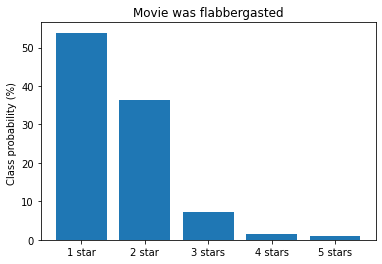

In [78]:

plt.bar(labels , 100*preds_df["score"],color="C0")
plt.title(f"{custom_review}")
plt.ylabel("Class probability (%) ")
plt.show()

In [70]:
print("hello")

hello
